# Speech Recognition: CNN for Spoken Language
畳み込みニューラルネットワークによる音声認識  
- https://chsasank.github.io/spoken-language-understanding.html

<img src="SR.png">

要点: 波形の形状のパターンを学習することで、畳み込みによって特徴を抽出する

### Process 手順
- 音声データ（Dataset: ）
- 波形獲得（.wav）
- 特徴抽出（転移学習: ）
- モデル構築（CNN）

### Terminology 専門用語
- メル周波数ケプストラム係数（MFCC）

## Step 1. Data Preparation

In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
ls

0315_speech_recognition.ipynb  UrbanSound8K/
RECENT_Notebook.ipynb          UrbanSound8K.csv
SR.png                         speech_recognition.ipynb
SRD.png


In [79]:
sounds = pd.read_csv('UrbanSound8K.csv')
sounds.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing


In [80]:
len(sounds)

8732

In [81]:
#classの数
sounds.classID.unique()

array([3, 2, 1, 0, 9, 6, 8, 5, 7, 4])

In [82]:
# 一定の長さ以上のデータのみを対象にする 3秒以上
sounds = sounds[sounds["end"] - sounds["start"] >= 2]
sounds.set_index("fsID")
sounds = sounds[["slice_file_name", "classID", "fold"]]
sounds.head()

,slice_file_name,classID,fold
1,100263-2-0-117.wav,2,5
2,100263-2-0-121.wav,2,5
3,100263-2-0-126.wav,2,5
4,100263-2-0-137.wav,2,5
5,100263-2-0-143.wav,2,5


In [83]:
sounds.shape

(7750, 3)

In [86]:
#classの数
sounds.classID.unique()
print(len(sounds.classID.unique()))

10


## Visualize Spectglam スペクトグラムの可視化

In [6]:
# AC
path1 = "/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/fold1/7061-6-0-0.wav"
# 音声データの読み込み
y, sr = librosa.load(path1, duration=3.0)
# メル周波係数の取得
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 97)

In [7]:
librosa.display.specshow(ps, y_axis="mel", x_axis="time", cmap="summer")

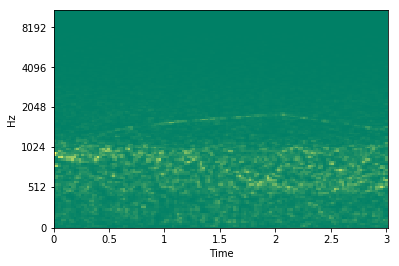

In [8]:
# chirdlen
path2 = "/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/fold6/135160-8-0-0.wav"
y, sr = librosa.load(path2, duration=3.0)
ps2 = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps2, y_axis="mel", x_axis="time", cmap="summer")

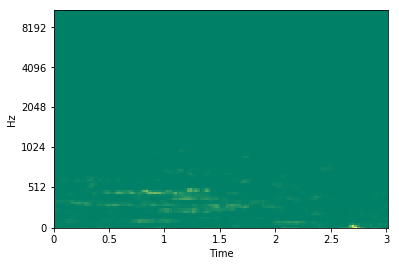

In [9]:
# chirdlen
path2 = "/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/fold5/6508-9-0-1.wav"
y, sr = librosa.load(path2, duration=3.0)
ps2 = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps2, y_axis="mel", x_axis="time", cmap="summer")

In [93]:
# .wavデータを集めるためのパスづくり
base_path = "/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/fold"
sounds["path"] = base_path + sounds["fold"].astype("str") + "/" +sounds["slice_file_name"].astype("str")
sounds.head()

,slice_file_name,classID,fold,path
1,100263-2-0-117.wav,2,5,/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/...
2,100263-2-0-121.wav,2,5,/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/...
3,100263-2-0-126.wav,2,5,/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/...
4,100263-2-0-137.wav,2,5,/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/...
5,100263-2-0-143.wav,2,5,/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/...


In [142]:
for row in sounds.itertuples():
    print(row[4])
    break

/Users/akr712/Desktop/音声認識/UrbanSound8K/audio/fold5/100263-2-0-117.wav


In [109]:
print(len(sounds.classID.unique()))

10


In [123]:
# listにデータを集める
classes = []
speeches = []
for row in sounds.itertuples():
    y, sr = librosa.load(row[4], duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): 
        continue
    classes.append(row[2])
    speeches.append(ps)

In [126]:
np.unique(classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [127]:
len(np.unique(classes))

10

In [129]:
len(speeches)

7478

## Reshape: Speech Data and Categorical One Hot for labels

![](http://dkopczyk.quantee.co.uk/wp-content/uploads/2018/08/wav-768x132.png)

In [131]:
ps = []
for speech in speeches:
    re = np.array(speech.reshape((128, 128, 1)))
    ps.append(re)

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ps, classes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = (train_test_split(X_train, y_train, test_size=0.2, random_state=42))

In [149]:
from keras.utils import to_categorical
y_train = np.array(to_categorical(y_train, 10))
y_test = np.array(to_categorical(y_test, 10))
y_val = np.array(to_categorical(y_val, 10))

## Step 2. Build CNN Model
### CNN: Convolutional Neural Networks
The basic architecture of CNN includes:
1. Convolutional Layer – uses convolutional operator to filter input signal and extract some additional image features
2. Activation Function – applies non-linear function such as rectifier to the outputs of convolutional layer
3. Pooling Layer – performs a downsampling operation reducing the size of an input with max() or sum() operation
4. Fully-Connected Layer – each neuron in the previous layer is connected to each neuron on the next layer with last such layer producing outputs of neural network.

![](https://bookdown.org/wshuyi/dive-into-data-science-practically/assets/2018-06-27-11-12-04-076004.png)

In [133]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [134]:
# Modeling
features_shape = (128, 128, 1)

inputs = Input(shape=features_shape)

# Block 1
o = Conv2D(24, (5, 5), strides=(1, 1), input_shape=features_shape)(inputs)
o = MaxPooling2D(pool_size=(4, 2), strides=(4, 2))(o)
# o = Activation('relu')(o)
o = BatchNormalization()(o)

# Block 2
o = Conv2D(48, (5, 5), padding="valid")(o)
o = MaxPooling2D((4, 2), strides=(4, 2))(o)
# o = Activation('relu')(o)
o = BatchNormalization()(o)

# Block 3
o = Conv2D(48, (5, 5), padding="valid")(o)
o = Activation("relu")(o)

# Flatten
o = Flatten()(o)
# o = Dropout(rate=0.5)(o)

# Dense layer
o = Dense(64, activation="relu")(o)
o = BatchNormalization()(o)
o = Dropout(rate=0.5)(o)

# Predictions
outputs = Dense(10, activation="softmax")(o)

model = Model(inputs, outputs)

In [135]:
features_shape

(128, 128, 1)

In [136]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 31, 62, 24)        96        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 29, 48)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 6, 29, 48)         192       
__________

In [137]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Step 3. Training CNN for Classification

In [140]:
EPOCHS = 5
BATCH_SIZE = 32

In [150]:
history = model.fit(np.asarray(X_train),  np.asarray(y_train), 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE,
                     validation_data=(np.asarray(X_val), np.asarray(y_val)))

Train on 4785 samples, validate on 1197 samples
Epoch 1/5
4785/4785 [==============================] - 281s 59ms/step - loss: 2.2878 - acc: 0.2466 - val_loss: 2.9128 - val_acc: 0.1838
Epoch 2/5
4785/4785 [==============================] - 164s 34ms/step - loss: 1.8745 - acc: 0.3404 - val_loss: 1.9056 - val_acc: 0.2531
Epoch 3/5
4785/4785 [==============================] - 217s 45ms/step - loss: 1.7301 - acc: 0.3766 - val_loss: 1.9852 - val_acc: 0.2974
Epoch 4/5
4785/4785 [==============================] - 200s 42ms/step - loss: 1.6248 - acc: 0.4211 - val_loss: 2.1790 - val_acc: 0.2891
Epoch 5/5
4785/4785 [==============================] - 446s 93ms/step - loss: 1.5516 - acc: 0.4355 - val_loss: 1.9808 - val_acc: 0.3400


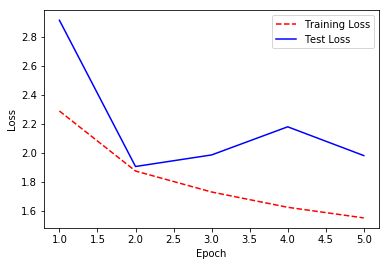

In [151]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

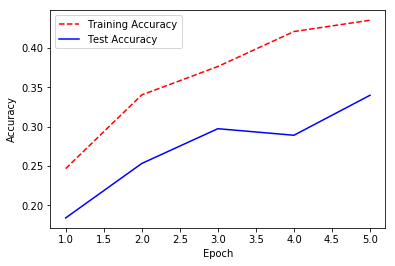

In [152]:
training_acc = history.history['acc']
test_acc = history.history['val_acc']

epoch_count = range(1, len(training_acc) + 1)

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

#### 今後: Data Augumentation を使った場合に分類の精度が向上するか試したい